In [1]:
from itertools import product
from pathlib import Path
import random

import h5py
import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import scipy
from tqdm import tqdm

# focal loss setup
!wget -qN https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.3/Exercises/EX05/focal_loss.py
from focal_loss import FocalLoss

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split, WeightedRandomSampler
from torchinfo import summary
import torchmetrics
from torchmetrics import MetricCollection
from torchmetrics.classification import (
    MulticlassAccuracy,
    MulticlassF1Score,
)
from torchvision.transforms import v2

def set_seed(seed=123456789):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    L.seed_everything(seed)

DATA_PROCESSED_PATH = Path(".", "..", "data", "preprocessed")
LABELED_TRAPS_PATH = DATA_PROCESSED_PATH / "labeled_traps.hdf5"
RESULTS_PATH = Path(".", "..", "data", "results")
LOGS_PATH = Path(".", "..", "logs")

rb_current = 3.2

In [2]:
TARGET_INDICES = np.array(
    [
        22,
        23,
        24,
        25,
        26,
        27,
        32,
        33,
        36,
        37,
        38,
        39,
        40,
        43,
        44,
        45,
        46,
        47,
        48,
        49,
        52,
        53,
        54,
        55,
        56,
        59,
        60,
        61,
        62,
        63,
        64,
        65,
        68,
        69,
        70,
        71,
        72,
        75,
        76,
        81,
        82,
        83,
        84,
        85,
        86,
    ]
)
# 20 perepherial + 25 center = 45
assert TARGET_INDICES.shape[0] == 45, "Wrong traps alignment"
TARGET_INDICES

TEXPS = np.array(
    [2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0]
)

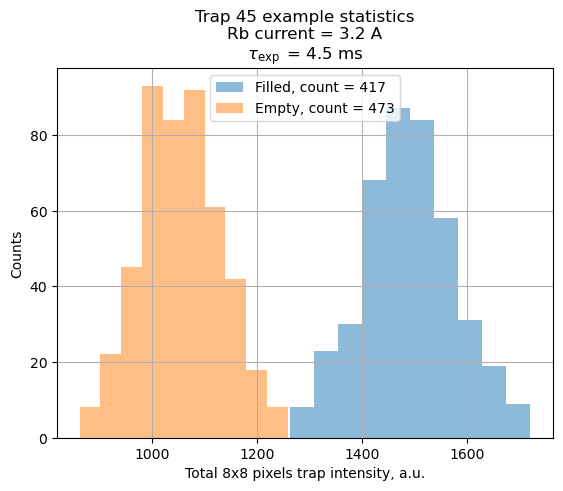

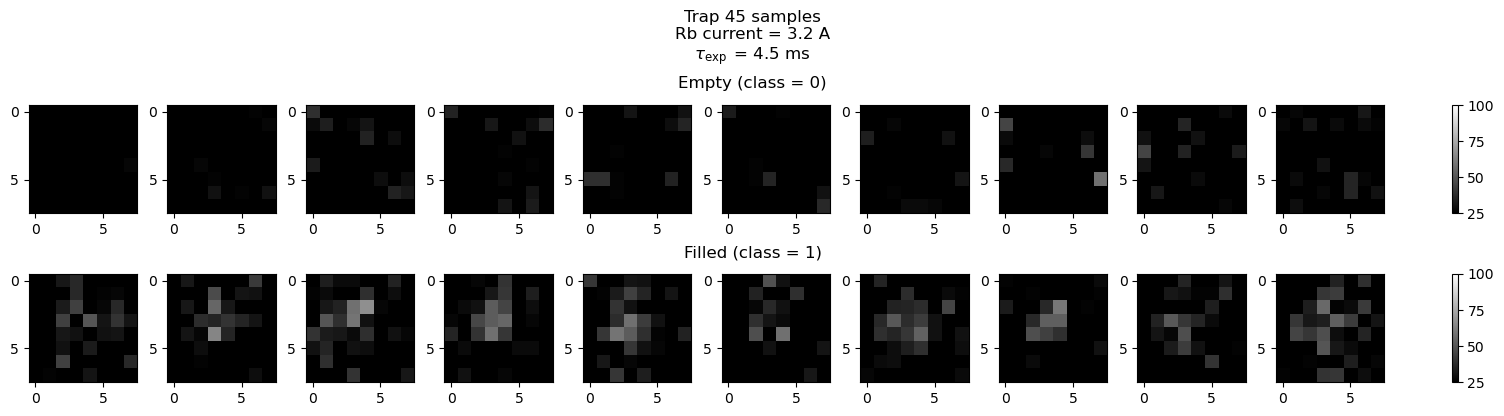

In [3]:
# readout example
with h5py.File(LABELED_TRAPS_PATH, "r") as f:
    texp = 4.5
    trap_ind = 45

    d = f[f"rb_{rb_current:.1f}/texp_{texp:.1f}/trap_{trap_ind}/filled"]
    filled = d[::]

    d = f[f"rb_{rb_current:.1f}/texp_{texp:.1f}/trap_{trap_ind}/empty"]
    empty = d[::]

# intensity hist
dat = np.concatenate((filled.sum(axis=(1, 2)), empty.sum(axis=(1, 2))), axis=0)
h = scipy.stats.iqr(dat) * 2 * dat.shape[0] ** (-1 / 3)
plt.hist(
    filled.sum(axis=(1, 2)),
    bins=round((dat.max() - dat.min()) / h),
    label=f"Filled, count = {filled.shape[0]}",
    alpha=0.5,
)
plt.hist(
    empty.sum(axis=(1, 2)),
    bins=round((dat.max() - dat.min()) / h),
    label=f"Empty, count = {empty.shape[0]}",
    alpha=0.5,
)
plt.xlabel("Total 8x8 pixels trap intensity, a.u.")
plt.ylabel("Counts")
plt.title(
    f"Trap {trap_ind} example statistics\nRb current = {rb_current:.1f} A\n" + r"$\tau_\exp$" + f" = {texp:.1f} ms"
)
plt.grid()
plt.legend()
plt.show()

# some data samples
N_SAMPLES = 10
fig = plt.figure(constrained_layout=True, figsize=(15, 4))
fig.suptitle(
    f"Trap {trap_ind} samples\nRb current = {rb_current:.1f} A\n" + r"$\tau_\exp$" + f" = {texp:.1f} ms"
)
subfigs = fig.subfigures(nrows=2, ncols=1)
for row, subfig in enumerate(subfigs):
    if row == 0:
        subfig.suptitle("Empty (class = 0)")
    else:
        subfig.suptitle("Filled (class = 1)")

    # create subplots
    axs = subfig.subplots(nrows=1, ncols=N_SAMPLES)
    for col, ax in enumerate(axs):
        if row == 0:
            im = axs[col].imshow(empty[col], vmin=25, vmax=100, cmap="grey")
        else:
            im = axs[col].imshow(filled[col], vmin=25, vmax=100, cmap="grey")
    fig.colorbar(im, ax=axs.ravel().tolist())
plt.show()

# Custom dataset class

In [4]:
class CustomHDF5DatasetAllTraps(Dataset):
    """
    Custom Dataset for HDF5 loading
    """
    class_name_to_idx:dict = {"empty": 0, "filled": 1}

    def __init__(
        self,
        hdf5_path,
        rb_current: float = 3.2,
        texp: float = 9.0,
        transform=None,
    ):
        self.transform = transform
        self.data = []
        self.labels = []

        with h5py.File(hdf5_path, "r") as f:
            for class_name, trap_ind in product(["empty", "filled"], TARGET_INDICES):
                d = f[
                    f"rb_{rb_current:.1f}/texp_{texp:.1f}/trap_{trap_ind}/{class_name}"
                ]
                images = d[::]
                images = images.astype(np.uint8)

                self.data.extend([PIL.Image.fromarray(x, mode="L") for x in images])
                self.labels.extend([self.class_name_to_idx[class_name]] * images.shape[0])
        self.labels = np.array(self.labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# NN pipeline

In [5]:
set_seed()

Seed set to 123456789


In [6]:
if torch.cuda.is_available():
    print(f"Found CUDA device: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA device is not found")

Found CUDA device: NVIDIA GeForce RTX 3050 4GB Laptop GPU


In [7]:
batch_size = 64
texp = 9.0

generator = torch.Generator()
generator.manual_seed(1234567)

transforms = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=False),
    ]
)
custom_dataset = CustomHDF5DatasetAllTraps(
    LABELED_TRAPS_PATH,
    transform=transforms,
    rb_current=rb_current,
    texp=texp,
)
train_dataset, val_dataset, test_dataset = random_split(
    custom_dataset, 
    [0.8, 0.1, 0.1],
    generator=generator
)

# define sampler weights
class_counts = [
    custom_dataset.labels[train_dataset.indices].shape[0]
    - custom_dataset.labels[train_dataset.indices].sum(),
    custom_dataset.labels[train_dataset.indices].sum(),
]
class_counts = np.array(class_counts)
print(f"{class_counts = }")

weights_for_classes = class_counts.max() / class_counts
print(f"{weights_for_classes = }")

weight_for_every_sample = weights_for_classes[
    custom_dataset.labels[train_dataset.indices]
]
weight_for_every_sample.shape

# use sampler or not
# NOTE: sampler does not require to use `shuffle` option
sampler = WeightedRandomSampler(
    weights=weight_for_every_sample,
    num_samples=custom_dataset.labels[train_dataset.indices].shape[0],
    generator=generator,
) # or None

train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    sampler=sampler,
    generator=generator,
)
g = torch.Generator()
g.manual_seed(0)
val_loader = DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    sampler=None,
    generator=generator,
)
g = torch.Generator()
g.manual_seed(0)
test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    sampler=None,
    generator=generator,
)

class_counts = array([18021, 13727])
weights_for_classes = array([1.        , 1.31281416])


In [8]:
all_sum = []
all_sqr_sum = []
for img_batch, label_batch in tqdm(train_loader):
    for img, label in zip(img_batch, label_batch):
        all_sum.append(img.sum().numpy())
        all_sqr_sum.append((img**2).sum().numpy())
        class_counts[label.item()] += 1

        assert img.flatten().shape[0] == 64

print(f"{img.flatten().shape[0] = }")

all_sum = np.array(all_sum)
all_sqr_sum = np.array(all_sqr_sum)

mean = torch.as_tensor(all_sum, dtype=torch.float32).mean() / img.flatten().shape[0]
var = (
    torch.as_tensor(all_sqr_sum, dtype=torch.float32).mean() / img.flatten().shape[0]
    - mean**2
)
std = var.sqrt()

print(f"{mean = }\n {std = }")

100%|██████████| 497/497 [00:01<00:00, 292.13it/s]

img.flatten().shape[0] = 64
mean = tensor(23.7623)
 std = tensor(14.9251)


In [9]:
all_transforms = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean.reshape(-1, 1) / 255, std.reshape(-1, 1) / 255),
        v2.RandomVerticalFlip(p=0.5),
        v2.RandomHorizontalFlip(p=0.5),
    ]
)

custom_dataset.transform = all_transforms

## CNN baseline

In [11]:
%load_ext tensorboard
%tensorboard --logdir ./../logs/test_cnn_logs --port 6007

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6007 (pid 250852), started 0:00:03 ago. (Use '!kill 250852' to kill it.)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [13]:
class CNN_baseline(nn.Module):
    def __init__(self, input_shape=(1, 8, 8)):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=0),
            nn.ReLU(),  # [batch, 16, 6, 6]
            nn.BatchNorm2d(16),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=0),
            nn.ReLU(),  # [batch, 32, 4, 4]
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=0),
            nn.ReLU(),  # [batch, 64, 2, 2]
            nn.BatchNorm2d(64),
        )
        self.classifer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=64 * 2 * 2, out_features=64),
            nn.Tanh(),
            nn.Dropout(0.5),
            nn.Linear(in_features=64, out_features=2),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifer(x)
        return x

In [14]:
class SummaryErrorMetric(torchmetrics.Metric):
    def __init__(self, threshold=0.5):
        super().__init__()
        self.threshold = threshold
        self.add_state("fp", default=torch.tensor(0), dist_reduce_fx="sum")
        self.add_state("fn", default=torch.tensor(0), dist_reduce_fx="sum")
        self.add_state("tn", default=torch.tensor(0), dist_reduce_fx="sum")
        self.add_state("tp", default=torch.tensor(0), dist_reduce_fx="sum")

    def update(self, preds, target):
        # preds shape: [batch_size, 2] (softmax outputs for 2 classes)
        preds = preds[:, 1]  # Use probability of class 1
        preds = (preds >= self.threshold).long()  # Threshold to get binary predictions
        target = target.long()

        # Calculate confusion matrix components
        tp = torch.sum((preds == 1) & (target == 1)) # cnt_11
        tn = torch.sum((preds == 0) & (target == 0)) # cnt_00
        fp = torch.sum((preds == 1) & (target == 0)) # cnt_10
        fn = torch.sum((preds == 0) & (target == 1)) # cnt_01

        # Update states
        self.tp += tp
        self.tn += tn
        self.fp += fp
        self.fn += fn

    def compute(self) -> dict:
        # Avoid division by zero
        fpr = self.fp.float() / (self.fp + self.tn + 1e-16)
        fnr = self.fn.float() / (self.fn + self.tp + 1e-16)
        return {
            "SummaryErrorMetric": fpr + fnr, 
            "cnt_11": self.tp.float(), 
            "cnt_00": self.tn.float(), 
            "cnt_10": self.fp.float(), 
            "cnt_01": self.fn.float()
        }

In [15]:
class LModel(L.LightningModule):
    def __init__(self, model, lr=0.001):
        super().__init__()

        self.save_hyperparameters(ignore=["model"])

        self.lr = lr
        self.model = model
        self.criterion = FocalLoss(gamma=2.0)

        # metrics
        self.metrics = MetricCollection(
            [
                MulticlassAccuracy(
                    num_classes=2,
                ),
                MulticlassF1Score(
                    num_classes=2,
                ),
                SummaryErrorMetric(),
            ]
        )
        self.train_metrics = self.metrics.clone(postfix="/train")
        self.val_metrics = self.metrics.clone(postfix="/val")

    def configure_optimizers(self):
        # set optimizer
        optimizer = torch.optim.Adam(
            self.model.parameters(),
            lr=self.lr,
        )
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "epoch",  # or 'step'
                "monitor": "loss/val",  # only for self.log
            },
        }

    def training_step(self, batch, batch_idx):
        x, y = batch
        out = self.model(x)
        loss = self.criterion(out, y)
        self.train_metrics.update(out.softmax(-1), y)
        self.log("loss/trian", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        out = self.model(x)
        loss = self.criterion(out, y)
        self.log("loss/val", loss, prog_bar=True)
        self.val_metrics.update(out.softmax(-1), y)

    def on_train_epoch_end(self):
        self.log_dict(self.train_metrics.compute())
        self.train_metrics.reset()

        self.log_dict(self.val_metrics.compute())
        self.val_metrics.reset()

    def test_step(self, batch, batch_idx):
        x, y = batch
        out = self.model(x)
        self.metrics.update(out.softmax(-1), y)

    def on_test_epoch_end(self):
        self.log_dict(self.metrics.compute())
        self.metrics.reset()

## Test training

In [16]:
max_epochs = 3

model = CNN_baseline()
pl_model = LModel(model=model)

checkpoint_callback = ModelCheckpoint(
    monitor="SummaryErrorMetric/val", mode="min", filename="best"
)

logger = TensorBoardLogger(save_dir=LOGS_PATH / "test_cnn_logs", name="test")

trainer = L.Trainer(
    deterministic="warn",
    max_epochs=max_epochs,
    callbacks=[checkpoint_callback],
    num_sanity_val_steps=0,
    log_every_n_steps=1,
    logger=logger,
    enable_progress_bar=False,
    enable_model_summary=False
)

trainer.fit(model=pl_model, train_dataloaders=train_loader, val_dataloaders=val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3050 4GB Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/ctrlc0ctrlv/miniconda3/envs/rb87_detection_env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/ctrlc0ctrlv/miniconda3/envs/rb87_detection_env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
`Trainer.fit` stopped: `max_epochs=3` reached.


In [17]:
result = trainer.test(
    model=pl_model, dataloaders=test_loader, verbose=True, ckpt_path="best"
)
result

Restoring states from the checkpoint path at ../logs/test_cnn_logs/test/version_0/checkpoints/best.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ../logs/test_cnn_logs/test/version_0/checkpoints/best.ckpt
/home/ctrlc0ctrlv/miniconda3/envs/rb87_detection_env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   MulticlassAccuracy        0.99868243932724
    MulticlassF1Score       0.9987167716026306
   SummaryErrorMetric      0.002635105513036251
         cnt_00                   2248.0
         cnt_01                     3.0
         cnt_10                     2.0
         cnt_11                   1715.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'MulticlassAccuracy': 0.99868243932724,
  'MulticlassF1Score': 0.9987167716026306,
  'SummaryErrorMetric': 0.002635105513036251,
  'cnt_11': 1715.0,
  'cnt_00': 2248.0,
  'cnt_10': 2.0,
  'cnt_01': 3.0}]

In [18]:
summary(model, input_size=(batch_size, 1, 8, 8))

Layer (type:depth-idx)                   Output Shape              Param #
CNN_baseline                             [64, 2]                   --
├─Sequential: 1-1                        [64, 64, 2, 2]            --
│    └─Conv2d: 2-1                       [64, 16, 6, 6]            160
│    └─ReLU: 2-2                         [64, 16, 6, 6]            --
│    └─BatchNorm2d: 2-3                  [64, 16, 6, 6]            32
│    └─Conv2d: 2-4                       [64, 32, 4, 4]            4,640
│    └─ReLU: 2-5                         [64, 32, 4, 4]            --
│    └─BatchNorm2d: 2-6                  [64, 32, 4, 4]            64
│    └─Conv2d: 2-7                       [64, 64, 2, 2]            18,496
│    └─ReLU: 2-8                         [64, 64, 2, 2]            --
│    └─BatchNorm2d: 2-9                  [64, 64, 2, 2]            128
├─Sequential: 1-2                        [64, 2]                   --
│    └─Flatten: 2-10                     [64, 256]                 --
│    └

In [19]:
from abc import ABC, abstractmethod

class Detector(ABC):
    """
    Abstract detector wrapper class
    """
    
    @abstractmethod
    def fit(self, train_loader, val_loader) -> None:
        ...
        
    @abstractmethod
    def predict(self, test_loader) -> dict:
        ...

class CNN_Detector(Detector):
    """
    CNN detector wrapper
    """
    max_epochs: int
    
    def __init__(self, max_epochs: int):
        self.max_epochs = max_epochs
    
    def fit(self, train_loader, val_loader, texp) -> None:
        """
        Train model
        """
        set_seed()
        model = CNN_baseline()
        self.pl_model = LModel(model=model)
        checkpoint_callback = ModelCheckpoint(
            monitor="SummaryErrorMetric/val", mode="min", filename="best"
        )
        logger = TensorBoardLogger(save_dir=LOGS_PATH / "logs_cnn_10_epoch", name=f"texp_{texp}")
        self.trainer = L.Trainer(
            max_epochs=self.max_epochs,
            callbacks=[checkpoint_callback],
            num_sanity_val_steps=0,
            log_every_n_steps=1,
            logger=logger,
            enable_progress_bar=False,
            enable_model_summary=False
        )
        self.trainer.fit(
            model=pl_model, train_dataloaders=train_loader, val_dataloaders=val_loader
        )

    def predict(self, test_loader) -> dict:
        """
        Test model
        """
        return self.trainer.test(
            model=self.pl_model, dataloaders=test_loader, verbose=True, ckpt_path="best"
        )

## Define function to train any detector on single texp data

In [20]:
def train_test_detector_one_texp(
    detector: Detector,
    texp: float = 9.0,
    rb_current: float = 3.2,
    batch_size: int = 32,
):
    # load train data
    transforms = v2.Compose(
        [
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=False),
        ]
    )
    
    set_seed()
    generator = torch.Generator()
    generator.manual_seed(1234567)
    
    custom_dataset = CustomHDF5DatasetAllTraps(
        LABELED_TRAPS_PATH,
        transform=transforms,
        rb_current=rb_current,
        texp=texp,
    )
    train_dataset, val_dataset, test_dataset = random_split(
        custom_dataset, [0.8, 0.1, 0.1], generator=generator
    )

    # define sampler weights
    class_counts = [
        custom_dataset.labels[train_dataset.indices].shape[0]
        - custom_dataset.labels[train_dataset.indices].sum(),
        custom_dataset.labels[train_dataset.indices].sum(),
    ]
    class_counts = np.array(class_counts)
    print(f"{class_counts = }")
    weights_for_classes = class_counts.max() / class_counts
    print(f"{weights_for_classes = }")
    weight_for_every_sample = weights_for_classes[
        custom_dataset.labels[train_dataset.indices]
    ]

    # use sampler or not
    sampler = WeightedRandomSampler(
        weights=weight_for_every_sample,
        num_samples=custom_dataset.labels[train_dataset.indices].shape[0],
        generator=generator,
    )
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        sampler=sampler,
        generator=generator,
    )
    g = torch.Generator()
    g.manual_seed(0)
    val_loader = DataLoader(
        val_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        sampler=None,
        generator=generator,
    )
    g = torch.Generator()
    g.manual_seed(0)
    test_loader = DataLoader(
        test_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        sampler=None,
        generator=generator,
    )

    # compute mean and std for normalization
    all_sum = []
    all_sqr_sum = []
    for img_batch, label_batch in tqdm(train_loader):
        for img, label in zip(img_batch, label_batch):
            all_sum.append(img.sum().numpy())
            all_sqr_sum.append((img**2).sum().numpy())
            class_counts[label.item()] += 1

    all_sum = np.array(all_sum)
    all_sqr_sum = np.array(all_sqr_sum)
    mean = torch.as_tensor(all_sum, dtype=torch.float32).mean() / img.flatten().shape[0]
    var = (
        torch.as_tensor(all_sqr_sum, dtype=torch.float32).mean()
        / img.flatten().shape[0]
        - mean**2
    )
    std = var.sqrt()
    print(f"{mean = }\n {std = }")

    # apply normalization and 
    all_transforms = v2.Compose(
        [
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=False),
            v2.Normalize(mean.reshape(-1, 1), std.reshape(-1, 1)),
            v2.RandomVerticalFlip(p=0.5),
            v2.RandomHorizontalFlip(p=0.5),
        ]
    )
    custom_dataset.transforms = all_transforms

    detector.fit(train_loader=train_loader, val_loader=val_loader, texp=texp)
    result = detector.predict(test_loader=test_loader)
    return result

In [21]:
cnn_detector = CNN_Detector(max_epochs=10)

results = []
for texp in tqdm(TEXPS):
    res = train_test_detector_one_texp(
        detector = cnn_detector,
        rb_current=rb_current, 
        texp=texp, 
        batch_size=batch_size,
    )[0]
    results.append(
        {
            "texp": texp,
            "rb_current": rb_current,
            "MulticlassAccuracy": res["MulticlassAccuracy"],
            "MulticlassF1Score": res["MulticlassF1Score"],
            "SummaryErrorMetric": res["SummaryErrorMetric"],
            "cnt_00": res["cnt_00"],
            "cnt_01": res["cnt_01"],
            "cnt_10": res["cnt_10"],
            "cnt_11": res["cnt_11"]
        }
    )

  0%|          | 0/15 [00:00<?, ?it/s]Seed set to 123456789


class_counts = array([17779, 14235])
weights_for_classes = array([1.        , 1.24896382])


100%|██████████| 501/501 [00:01<00:00, 253.28it/s]
Seed set to 123456789
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


mean = tensor(16.4251)
 std = tensor(7.7444)


`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at ../logs/logs_cnn_10_epoch/texp_2.0/version_0/checkpoints/best.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ../logs/logs_cnn_10_epoch/texp_2.0/version_0/checkpoints/best.ckpt
  7%|▋         | 1/15 [00:50<11:40, 50.06s/it]Seed set to 123456789


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   MulticlassAccuracy       0.9575554132461548
    MulticlassF1Score       0.9570176601409912
   SummaryErrorMetric       0.08488914370536804
         cnt_00                   2179.0
         cnt_01                    76.0
         cnt_10                    93.0
         cnt_11                   1653.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
class_counts = array([18303, 13804])
weights_for_classes = array([1.        , 1.32592002])


100%|██████████| 502/502 [00:02<00:00, 237.50it/s]
Seed set to 123456789
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


mean = tensor(17.0612)
 std = tensor(8.1559)


`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at ../logs/logs_cnn_10_epoch/texp_2.5/version_0/checkpoints/best.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ../logs/logs_cnn_10_epoch/texp_2.5/version_0/checkpoints/best.ckpt
 13%|█▎        | 2/15 [01:39<10:43, 49.48s/it]Seed set to 123456789


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   MulticlassAccuracy       0.9802849292755127
    MulticlassF1Score       0.9805876612663269
   SummaryErrorMetric       0.03943004086613655
         cnt_00                   2282.0
         cnt_01                    42.0
         cnt_10                    34.0
         cnt_11                   1655.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
class_counts = array([17624, 13888])
weights_for_classes = array([1.        , 1.26900922])


100%|██████████| 493/493 [00:01<00:00, 281.51it/s]
Seed set to 123456789
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


mean = tensor(17.8118)
 std = tensor(8.6105)


`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at ../logs/logs_cnn_10_epoch/texp_3.0/version_0/checkpoints/best.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ../logs/logs_cnn_10_epoch/texp_3.0/version_0/checkpoints/best.ckpt
 20%|██        | 3/15 [02:37<10:39, 53.32s/it]Seed set to 123456789


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   MulticlassAccuracy        0.986624002456665
    MulticlassF1Score       0.9869065284729004
   SummaryErrorMetric      0.026751961559057236
         cnt_00                   2152.0
         cnt_01                    31.0
         cnt_10                    20.0
         cnt_11                   1736.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
class_counts = array([17429, 14283])
weights_for_classes = array([1.        , 1.22026185])


100%|██████████| 496/496 [00:01<00:00, 260.02it/s]
Seed set to 123456789
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


mean = tensor(18.2387)
 std = tensor(9.0017)


`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at ../logs/logs_cnn_10_epoch/texp_3.5/version_0/checkpoints/best.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ../logs/logs_cnn_10_epoch/texp_3.5/version_0/checkpoints/best.ckpt
 27%|██▋       | 4/15 [03:21<09:09, 49.98s/it]Seed set to 123456789


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   MulticlassAccuracy        0.993647575378418
    MulticlassF1Score       0.9938680529594421
   SummaryErrorMetric      0.012704828754067421
         cnt_00                   2190.0
         cnt_01                    16.0
         cnt_10                     8.0
         cnt_11                   1749.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
class_counts = array([17347, 14352])
weights_for_classes = array([1.        , 1.20868172])


100%|██████████| 496/496 [00:01<00:00, 255.86it/s]
Seed set to 123456789
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


mean = tensor(18.8051)
 std = tensor(9.5009)


`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at ../logs/logs_cnn_10_epoch/texp_4.0/version_0/checkpoints/best.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ../logs/logs_cnn_10_epoch/texp_4.0/version_0/checkpoints/best.ckpt
 33%|███▎      | 5/15 [04:06<08:00, 48.07s/it]Seed set to 123456789


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   MulticlassAccuracy       0.9976708889007568
    MulticlassF1Score       0.9976993799209595
   SummaryErrorMetric      0.004658230114728212
         cnt_00                   2199.0
         cnt_01                     5.0
         cnt_10                     4.0
         cnt_11                   1754.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
class_counts = array([17872, 13589])
weights_for_classes = array([1.       , 1.3151814])


100%|██████████| 492/492 [00:01<00:00, 260.25it/s]
Seed set to 123456789
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


mean = tensor(19.2898)
 std = tensor(10.0501)


`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at ../logs/logs_cnn_10_epoch/texp_4.5/version_0/checkpoints/best.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ../logs/logs_cnn_10_epoch/texp_4.5/version_0/checkpoints/best.ckpt
 40%|████      | 6/15 [04:55<07:16, 48.51s/it]Seed set to 123456789


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   MulticlassAccuracy       0.9980671405792236
    MulticlassF1Score       0.9981805086135864
   SummaryErrorMetric      0.0038656683173030615
         cnt_00                   2251.0
         cnt_01                     5.0
         cnt_10                     2.0
         cnt_11                   1674.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
class_counts = array([17957, 13677])
weights_for_classes = array([1.        , 1.31293412])


100%|██████████| 495/495 [00:01<00:00, 272.62it/s]
Seed set to 123456789
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


mean = tensor(19.7705)
 std = tensor(10.4357)


`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at ../logs/logs_cnn_10_epoch/texp_5.0/version_0/checkpoints/best.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ../logs/logs_cnn_10_epoch/texp_5.0/version_0/checkpoints/best.ckpt
 47%|████▋     | 7/15 [05:40<06:19, 47.38s/it]Seed set to 123456789


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   MulticlassAccuracy       0.9993330240249634
    MulticlassF1Score       0.9992268085479736
   SummaryErrorMetric      0.0013339262222871184
         cnt_00                   2246.0
         cnt_01                     0.0
         cnt_10                     3.0
         cnt_11                   1705.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
class_counts = array([18007, 14023])
weights_for_classes = array([1.        , 1.28410469])


100%|██████████| 501/501 [00:01<00:00, 295.50it/s]
Seed set to 123456789
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


mean = tensor(20.1967)
 std = tensor(10.9970)


`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at ../logs/logs_cnn_10_epoch/texp_5.5/version_0/checkpoints/best.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ../logs/logs_cnn_10_epoch/texp_5.5/version_0/checkpoints/best.ckpt
 53%|█████▎    | 8/15 [06:33<05:42, 48.88s/it]Seed set to 123456789


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   MulticlassAccuracy       0.9992689490318298
    MulticlassF1Score       0.9992418885231018
   SummaryErrorMetric      0.001462124171666801
         cnt_00                   2214.0
         cnt_01                     1.0
         cnt_10                     2.0
         cnt_11                   1786.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
class_counts = array([17774, 13855])
weights_for_classes = array([1.        , 1.28285817])


100%|██████████| 495/495 [00:02<00:00, 230.90it/s]
Seed set to 123456789
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


mean = tensor(20.6440)
 std = tensor(11.4958)


`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at ../logs/logs_cnn_10_epoch/texp_6.0/version_0/checkpoints/best.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ../logs/logs_cnn_10_epoch/texp_6.0/version_0/checkpoints/best.ckpt
 60%|██████    | 9/15 [07:34<05:16, 52.83s/it]Seed set to 123456789


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   MulticlassAccuracy       0.9997072219848633
    MulticlassF1Score       0.9997422695159912
   SummaryErrorMetric      0.0005854800692759454
         cnt_00                   2245.0
         cnt_01                     1.0
         cnt_10                     0.0
         cnt_11                   1707.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
class_counts = array([17726, 13544])
weights_for_classes = array([1.        , 1.30877141])


100%|██████████| 489/489 [00:02<00:00, 179.81it/s]
Seed set to 123456789
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


mean = tensor(21.1062)
 std = tensor(12.1809)


`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at ../logs/logs_cnn_10_epoch/texp_6.5/version_0/checkpoints/best.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ../logs/logs_cnn_10_epoch/texp_6.5/version_0/checkpoints/best.ckpt
 67%|██████▋   | 10/15 [08:38<04:41, 56.24s/it]Seed set to 123456789


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   MulticlassAccuracy       0.9994111061096191
    MulticlassF1Score       0.9994792342185974
   SummaryErrorMetric      0.0011778563493862748
         cnt_00                   2210.0
         cnt_01                     2.0
         cnt_10                     0.0
         cnt_11                   1696.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
class_counts = array([18069, 13268])
weights_for_classes = array([1.        , 1.36184806])


100%|██████████| 490/490 [00:02<00:00, 196.80it/s]
Seed set to 123456789
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


mean = tensor(21.5650)
 std = tensor(12.7625)


`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at ../logs/logs_cnn_10_epoch/texp_7.0/version_0/checkpoints/best.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ../logs/logs_cnn_10_epoch/texp_7.0/version_0/checkpoints/best.ckpt
 73%|███████▎  | 11/15 [09:26<03:34, 53.73s/it]Seed set to 123456789


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   MulticlassAccuracy       0.9996947050094604
    MulticlassF1Score       0.9997376203536987
   SummaryErrorMetric      0.0006105006323195994
         cnt_00                   2279.0
         cnt_01                     1.0
         cnt_10                     0.0
         cnt_11                   1637.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
class_counts = array([17726, 14259])
weights_for_classes = array([1.        , 1.24314468])


100%|██████████| 500/500 [00:01<00:00, 272.51it/s]
Seed set to 123456789
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


mean = tensor(22.0287)
 std = tensor(13.1542)


`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at ../logs/logs_cnn_10_epoch/texp_7.5/version_0/checkpoints/best.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ../logs/logs_cnn_10_epoch/texp_7.5/version_0/checkpoints/best.ckpt
 80%|████████  | 12/15 [10:13<02:34, 51.65s/it]Seed set to 123456789


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   MulticlassAccuracy       0.9988851547241211
    MulticlassF1Score       0.9989886283874512
   SummaryErrorMetric      0.002229654463008046
         cnt_00                   2204.0
         cnt_01                     4.0
         cnt_10                     0.0
         cnt_11                   1790.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
class_counts = array([18301, 13275])
weights_for_classes = array([1.       , 1.3786064])


100%|██████████| 494/494 [00:02<00:00, 206.08it/s]
Seed set to 123456789
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


mean = tensor(22.9757)
 std = tensor(14.0929)


`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at ../logs/logs_cnn_10_epoch/texp_8.0/version_0/checkpoints/best.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ../logs/logs_cnn_10_epoch/texp_8.0/version_0/checkpoints/best.ckpt
 87%|████████▋ | 13/15 [11:11<01:47, 53.69s/it]Seed set to 123456789


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   MulticlassAccuracy               1.0
    MulticlassF1Score               1.0
   SummaryErrorMetric               0.0
         cnt_00                   2309.0
         cnt_01                     0.0
         cnt_10                     0.0
         cnt_11                   1638.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
class_counts = array([18004, 13996])
weights_for_classes = array([1.        , 1.28636753])


100%|██████████| 500/500 [00:02<00:00, 226.79it/s]
Seed set to 123456789
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


mean = tensor(23.1628)
 std = tensor(14.1349)


`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at ../logs/logs_cnn_10_epoch/texp_8.5/version_0/checkpoints/best.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ../logs/logs_cnn_10_epoch/texp_8.5/version_0/checkpoints/best.ckpt
 93%|█████████▎| 14/15 [12:12<00:55, 55.79s/it]Seed set to 123456789


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   MulticlassAccuracy       0.9997730255126953
    MulticlassF1Score       0.9997473359107971
   SummaryErrorMetric     0.00045392647734843194
         cnt_00                   2202.0
         cnt_01                     0.0
         cnt_10                     1.0
         cnt_11                   1796.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
class_counts = array([18021, 13727])
weights_for_classes = array([1.        , 1.31281416])


100%|██████████| 497/497 [00:02<00:00, 222.79it/s]
Seed set to 123456789
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


mean = tensor(23.7623)
 std = tensor(14.9251)


`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at ../logs/logs_cnn_10_epoch/texp_9.0/version_0/checkpoints/best.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ../logs/logs_cnn_10_epoch/texp_9.0/version_0/checkpoints/best.ckpt
100%|██████████| 15/15 [13:14<00:00, 52.98s/it]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   MulticlassAccuracy        0.99868243932724
    MulticlassF1Score       0.9987167716026306
   SummaryErrorMetric      0.002635105513036251
         cnt_00                   2248.0
         cnt_01                     3.0
         cnt_10                     2.0
         cnt_11                   1715.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [22]:
df = pd.DataFrame(results)
df

,texp,rb_current,MulticlassAccuracy,MulticlassF1Score,SummaryErrorMetric,cnt_00,cnt_01,cnt_10,cnt_11
0,2.0,3.2,0.957555,0.957018,0.084889,2179.0,76.0,93.0,1653.0
1,2.5,3.2,0.980285,0.980588,0.039430,2282.0,42.0,34.0,1655.0
2,3.0,3.2,0.986624,0.986907,0.026752,2152.0,31.0,20.0,1736.0
3,3.5,3.2,0.993648,0.993868,0.012705,2190.0,16.0,8.0,1749.0
4,4.0,3.2,0.997671,0.997699,0.004658,2199.0,5.0,4.0,1754.0
5,4.5,3.2,0.998067,0.998181,0.003866,2251.0,5.0,2.0,1674.0
6,5.0,3.2,0.999333,0.999227,0.001334,2246.0,0.0,3.0,1705.0
7,5.5,3.2,0.999269,0.999242,0.001462,2214.0,1.0,2.0,1786.0
8,6.0,3.2,0.999707,0.999742,0.000585,2245.0,1.0,0.0,1707.0
9,6.5,3.2,0.999411,0.999479,0.001178,2210.0,2.0,0.0,1696.0


In [23]:
df.to_csv(RESULTS_PATH / f"cnn_results_rb3.2_{cnn_detector.max_epochs}_epochs_all_traps.csv", index=False)

In [24]:
df = pd.read_csv(RESULTS_PATH / f"cnn_results_rb3.2_{cnn_detector.max_epochs}_epochs_all_traps.csv")
df

,texp,rb_current,MulticlassAccuracy,MulticlassF1Score,SummaryErrorMetric,cnt_00,cnt_01,cnt_10,cnt_11
0,2.0,3.2,0.957555,0.957018,0.084889,2179.0,76.0,93.0,1653.0
1,2.5,3.2,0.980285,0.980588,0.039430,2282.0,42.0,34.0,1655.0
2,3.0,3.2,0.986624,0.986907,0.026752,2152.0,31.0,20.0,1736.0
3,3.5,3.2,0.993648,0.993868,0.012705,2190.0,16.0,8.0,1749.0
4,4.0,3.2,0.997671,0.997699,0.004658,2199.0,5.0,4.0,1754.0
5,4.5,3.2,0.998067,0.998181,0.003866,2251.0,5.0,2.0,1674.0
6,5.0,3.2,0.999333,0.999227,0.001334,2246.0,0.0,3.0,1705.0
7,5.5,3.2,0.999269,0.999242,0.001462,2214.0,1.0,2.0,1786.0
8,6.0,3.2,0.999707,0.999742,0.000585,2245.0,1.0,0.0,1707.0
9,6.5,3.2,0.999411,0.999479,0.001178,2210.0,2.0,0.0,1696.0


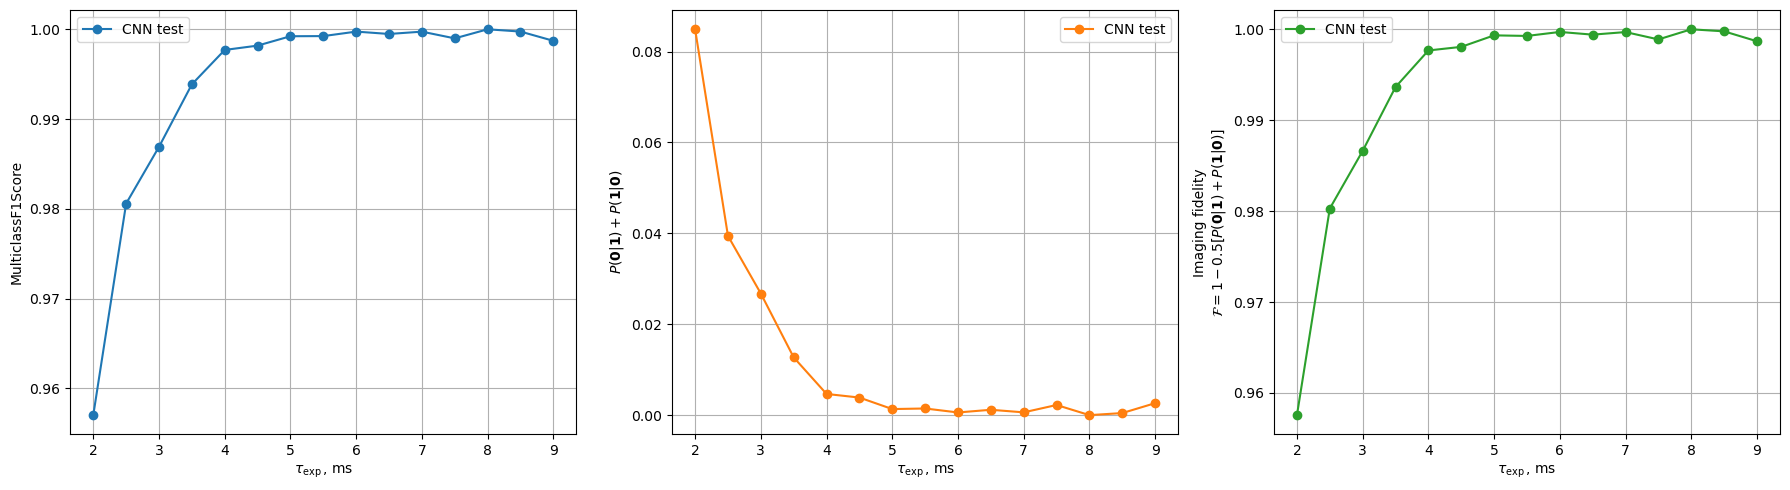

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

data_cnt = df.groupby(by="texp").MulticlassF1Score.count()
data_mean = df.groupby(by="texp").MulticlassF1Score.mean()
ax[0].plot(
    data_mean.index,
    data_mean.values.copy(),
    "-o",
    label="CNN test",
    color="C0",
)
ax[0].set_xlabel(r"$\tau_\exp$, ms")
ax[0].set_ylabel("MulticlassF1Score")
ax[0].grid()
ax[0].legend()

data_cnt = df.groupby(by="texp").SummaryErrorMetric.count()
data_mean = df.groupby(by="texp").SummaryErrorMetric.mean()
ax[1].plot(
    data_mean.index,
    data_mean.values.copy(),
    "-o",
    label="CNN test",
    color="C1",
)
ax[1].set_xlabel(r"$\tau_\exp$, ms")
ax[1].set_ylabel(r"$P(\mathbf{0}|\mathbf{1}) + P(\mathbf{1}|\mathbf{0})$")
ax[1].grid()
ax[1].legend()

data_cnt = df.groupby(by="texp").SummaryErrorMetric.count()
data_mean = df.groupby(by="texp").SummaryErrorMetric.mean()
ax[2].plot(
    data_mean.index,
    1 - data_mean.values.copy() / 2,
    "-o",
    label="CNN test",
    color="C2",
)
ax[2].set_xlabel(r"$\tau_\exp$, ms")
ax[2].set_ylabel("Imaging fidelity\n" + r"$\mathcal{F} = 1 - 0.5 \left[ P(\mathbf{0}|\mathbf{1}) + P(\mathbf{1}|\mathbf{0}) \right]$")
ax[2].grid()
ax[2].legend()

plt.tight_layout()
plt.show()

# Threshold detector

In [26]:
class Threshold_Detector(Detector):
    """
    Threshold detector wrapper
    """
    threshold: int
    
    def fit(self, train_loader, val_loader, texp) -> None:
        """
        Train model
        """
        threshold_values = []
        all_labels = []
        all_stats = []
        
        threshold_vs_error = {}

        min_error = np.inf

        for img, label in train_loader:
            all_stats.extend(img.sum(axis=(1, 2, 3)))
            all_labels.extend(label)

        all_stats, all_labels = np.array(all_stats), np.array(all_labels)

        # get minimal sum error
        for threshold in np.arange(all_stats.min(), all_stats.max(), 1):
            class_result = all_stats >= threshold
            errors_p10 = ((class_result == 1) & (all_labels == 0)).sum() / (
                all_labels == 0
            ).sum()
            errors_p01 = ((class_result == 0) & (all_labels == 1)).sum() / (
                all_labels == 1
            ).sum()

            if errors_p01 + errors_p10 < min_error:
                min_error = errors_p01 + errors_p10
            
            threshold_vs_error[threshold] = errors_p01 + errors_p10

        # get median of the thresholds with minimal error
        for threshold, error in threshold_vs_error.items():
            if np.isclose(error, min_error):
                threshold_values.append(threshold)

        self.threshold = np.median(threshold_values)

    def predict(self, test_loader) -> dict:
        """
        Test model
        """
        
        all_labels = []
        all_stats = []

        for img, label in test_loader:
            all_stats.extend(img.sum(axis=(1, 2, 3)))
            all_labels.extend(label)

        all_stats, all_labels = np.array(all_stats), np.array(all_labels).astype(int)

        class_result = (all_stats >= self.threshold).astype(int)
        cnt_00 = ((class_result == 0) & (all_labels == 0)).sum()
        cnt_01 = ((class_result == 0) & (all_labels == 1)).sum()
        cnt_10 = ((class_result == 1) & (all_labels == 0)).sum()
        cnt_11 = ((class_result == 1) & (all_labels == 1)).sum()

        return {"cnt_00": cnt_00, "cnt_01": cnt_01, "cnt_10": cnt_10, "cnt_11": cnt_11, "threshold": self.threshold}

In [27]:
results = []
threshold_detector = Threshold_Detector()

for texp in tqdm(TEXPS):
    res = train_test_detector_one_texp(
        detector=threshold_detector,
        rb_current=rb_current,
        texp=texp,
        batch_size=batch_size,
    )
    results.append(
        {
            "texp": texp,
            "rb_current": rb_current,
            "cnt_00": res["cnt_00"],
            "cnt_01": res["cnt_01"],
            "cnt_10": res["cnt_10"],
            "cnt_11": res["cnt_11"],
            "threshold": res["threshold"],
        }
    )

  0%|          | 0/15 [00:00<?, ?it/s]Seed set to 123456789


class_counts = array([17779, 14235])
weights_for_classes = array([1.        , 1.24896382])


100%|██████████| 501/501 [00:02<00:00, 177.40it/s]


mean = tensor(16.4251)
 std = tensor(7.7444)


  7%|▋         | 1/15 [00:05<01:23,  5.95s/it]Seed set to 123456789


class_counts = array([18303, 13804])
weights_for_classes = array([1.        , 1.32592002])


100%|██████████| 502/502 [00:02<00:00, 192.09it/s]


mean = tensor(17.0612)
 std = tensor(8.1559)


 13%|█▎        | 2/15 [00:11<01:16,  5.89s/it]Seed set to 123456789


class_counts = array([17624, 13888])
weights_for_classes = array([1.        , 1.26900922])


100%|██████████| 493/493 [00:02<00:00, 217.81it/s]


mean = tensor(17.8118)
 std = tensor(8.6105)


 20%|██        | 3/15 [00:16<01:05,  5.45s/it]Seed set to 123456789


class_counts = array([17429, 14283])
weights_for_classes = array([1.        , 1.22026185])


100%|██████████| 496/496 [00:02<00:00, 202.71it/s]


mean = tensor(18.2387)
 std = tensor(9.0017)


 27%|██▋       | 4/15 [00:22<01:02,  5.64s/it]Seed set to 123456789


class_counts = array([17347, 14352])
weights_for_classes = array([1.        , 1.20868172])


100%|██████████| 496/496 [00:02<00:00, 233.14it/s]


mean = tensor(18.8051)
 std = tensor(9.5009)


 33%|███▎      | 5/15 [00:27<00:53,  5.39s/it]Seed set to 123456789


class_counts = array([17872, 13589])
weights_for_classes = array([1.       , 1.3151814])


100%|██████████| 492/492 [00:02<00:00, 222.11it/s]


mean = tensor(19.2898)
 std = tensor(10.0501)


 40%|████      | 6/15 [00:32<00:46,  5.18s/it]Seed set to 123456789


class_counts = array([17957, 13677])
weights_for_classes = array([1.        , 1.31293412])


100%|██████████| 495/495 [00:02<00:00, 227.00it/s]


mean = tensor(19.7705)
 std = tensor(10.4357)


 47%|████▋     | 7/15 [00:37<00:40,  5.12s/it]Seed set to 123456789


class_counts = array([18007, 14023])
weights_for_classes = array([1.        , 1.28410469])


100%|██████████| 501/501 [00:02<00:00, 233.72it/s]


mean = tensor(20.1967)
 std = tensor(10.9970)


 53%|█████▎    | 8/15 [00:42<00:36,  5.16s/it]Seed set to 123456789


class_counts = array([17774, 13855])
weights_for_classes = array([1.        , 1.28285817])


100%|██████████| 495/495 [00:02<00:00, 206.82it/s]


mean = tensor(20.6440)
 std = tensor(11.4958)


 60%|██████    | 9/15 [00:47<00:31,  5.20s/it]Seed set to 123456789


class_counts = array([17726, 13544])
weights_for_classes = array([1.        , 1.30877141])


100%|██████████| 489/489 [00:02<00:00, 235.63it/s]


mean = tensor(21.1062)
 std = tensor(12.1809)


 67%|██████▋   | 10/15 [00:52<00:25,  5.12s/it]Seed set to 123456789


class_counts = array([18069, 13268])
weights_for_classes = array([1.        , 1.36184806])


100%|██████████| 490/490 [00:02<00:00, 223.86it/s]


mean = tensor(21.5650)
 std = tensor(12.7625)


 73%|███████▎  | 11/15 [00:57<00:20,  5.04s/it]Seed set to 123456789


class_counts = array([17726, 14259])
weights_for_classes = array([1.        , 1.24314468])


100%|██████████| 500/500 [00:02<00:00, 242.04it/s]


mean = tensor(22.0287)
 std = tensor(13.1542)


 80%|████████  | 12/15 [01:02<00:15,  5.01s/it]Seed set to 123456789


class_counts = array([18301, 13275])
weights_for_classes = array([1.       , 1.3786064])


100%|██████████| 494/494 [00:01<00:00, 315.45it/s]


mean = tensor(22.9757)
 std = tensor(14.0929)


 87%|████████▋ | 13/15 [01:06<00:09,  4.59s/it]Seed set to 123456789


class_counts = array([18004, 13996])
weights_for_classes = array([1.        , 1.28636753])


100%|██████████| 500/500 [00:01<00:00, 286.03it/s]


mean = tensor(23.1628)
 std = tensor(14.1349)


 93%|█████████▎| 14/15 [01:10<00:04,  4.40s/it]Seed set to 123456789


class_counts = array([18021, 13727])
weights_for_classes = array([1.        , 1.31281416])


100%|██████████| 497/497 [00:01<00:00, 303.76it/s]


mean = tensor(23.7623)
 std = tensor(14.9251)


100%|██████████| 15/15 [01:14<00:00,  4.94s/it]


In [28]:
df = pd.DataFrame(results)
df["cnt_0"] = df.cnt_00 + df.cnt_10
df["cnt_1"] = df.cnt_01 + df.cnt_11
df["p_01"] = df.cnt_01 / df.cnt_1
df["p_10"] = df.cnt_10 / df.cnt_0
df["error"] = df["p_01"] + df["p_10"]
df

,texp,rb_current,cnt_00,cnt_01,cnt_10,cnt_11,threshold,cnt_0,cnt_1,p_01,p_10,error
0,2.0,3.2,2028,175,244,1554,1048.0,2272,1729,0.101215,0.107394,0.208609
1,2.5,3.2,2173,129,143,1568,1090.0,2316,1697,0.076016,0.061744,0.137761
2,3.0,3.2,2093,70,79,1697,1131.0,2172,1767,0.039615,0.036372,0.075987
3,3.5,3.2,2140,51,58,1714,1165.0,2198,1765,0.028895,0.026388,0.055283
4,4.0,3.2,2147,29,56,1730,1196.0,2203,1759,0.016487,0.025420,0.041907
5,4.5,3.2,2220,17,33,1662,1226.0,2253,1679,0.010125,0.014647,0.024772
6,5.0,3.2,2235,13,14,1692,1270.0,2249,1705,0.007625,0.006225,0.013850
7,5.5,3.2,2197,9,19,1778,1287.0,2216,1787,0.005036,0.008574,0.013610
8,6.0,3.2,2235,12,10,1696,1331.0,2245,1708,0.007026,0.004454,0.011480
9,6.5,3.2,2203,9,7,1689,1354.5,2210,1698,0.005300,0.003167,0.008468


In [29]:
df.to_csv(RESULTS_PATH / f"threshold_rb{rb_current:.1f}.csv", index=False)

In [30]:
df = pd.read_csv(RESULTS_PATH / f"threshold_rb{rb_current:.1f}.csv")
df

,texp,rb_current,cnt_00,cnt_01,cnt_10,cnt_11,threshold,cnt_0,cnt_1,p_01,p_10,error
0,2.0,3.2,2028,175,244,1554,1048.0,2272,1729,0.101215,0.107394,0.208609
1,2.5,3.2,2173,129,143,1568,1090.0,2316,1697,0.076016,0.061744,0.137761
2,3.0,3.2,2093,70,79,1697,1131.0,2172,1767,0.039615,0.036372,0.075987
3,3.5,3.2,2140,51,58,1714,1165.0,2198,1765,0.028895,0.026388,0.055283
4,4.0,3.2,2147,29,56,1730,1196.0,2203,1759,0.016487,0.025420,0.041907
5,4.5,3.2,2220,17,33,1662,1226.0,2253,1679,0.010125,0.014647,0.024772
6,5.0,3.2,2235,13,14,1692,1270.0,2249,1705,0.007625,0.006225,0.013850
7,5.5,3.2,2197,9,19,1778,1287.0,2216,1787,0.005036,0.008574,0.013610
8,6.0,3.2,2235,12,10,1696,1331.0,2245,1708,0.007026,0.004454,0.011480
9,6.5,3.2,2203,9,7,1689,1354.5,2210,1698,0.005300,0.003167,0.008468


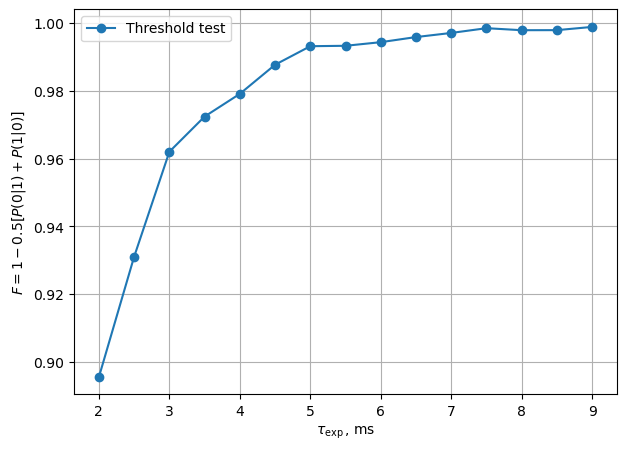

In [31]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))

data_cnt = df.groupby(by="texp").error.count()
data_mean = df.groupby(by="texp").error.mean()
data_std = df.groupby(by="texp").error.std()

ax.plot(
    data_mean.index,
    1 - data_mean.values / 2,
    "-o",
    label="Threshold test",
    color="C0",
)
ax.set_xlabel(r"$\tau_\exp$, ms")
ax.set_ylabel(r"$F = 1 - 0.5 \left[ P(0|1) + P(1|0) \right]$")
ax.grid()
ax.legend()

plt.show()

# Bayesian detector

In [32]:
class Bayesian_Detector(Detector):
    """
    Bayesian detector wrapper
    """
    img_mean_empty: np.ndarray
    img_std_empty: np.ndarray
    img_mean_filled: np.ndarray
    img_std_filled: np.ndarray
    p0: float
    p1: float
    
    def fit(self, train_loader, val_loader, texp) -> None:
        """
        Train model
        """
        img_sum_filled = np.zeros((8, 8))
        img_sum_sqr_filled = np.zeros((8, 8))
        img_sum_empty = np.zeros((8, 8))
        img_sum_sqr_empty = np.zeros((8, 8))

        filled_cnt = 0
        empty_cnt = 0

        for img_batch, label_batch in train_loader:
            for img, label in zip(img_batch, label_batch):
                if label == 1:
                    img_sum_filled += img.sum(axis=0).numpy()
                    img_sum_sqr_filled += img.sum(axis=0).numpy()**2
                    filled_cnt += 1
                else:
                    img_sum_empty += img.sum(axis=0).numpy()
                    img_sum_sqr_empty += img.sum(axis=0).numpy()**2
                    empty_cnt += 1

        img_mean_filled = img_sum_filled / filled_cnt
        img_mean_empty = img_sum_empty / empty_cnt

        img_std_filled = img_sum_sqr_filled / filled_cnt - img_mean_filled**2
        img_std_empty = img_sum_sqr_empty / empty_cnt - img_mean_empty**2

        p0 = empty_cnt / (empty_cnt + filled_cnt)
        p1 = filled_cnt / (empty_cnt + filled_cnt)
        
        self.img_mean_empty = img_mean_empty
        self.img_std_empty = img_std_empty
        self.img_mean_filled = img_mean_filled
        self.img_std_filled = img_std_filled
        self.p0 = p0
        self.p1= p1

    def predict(self, test_loader) -> dict:
        """
        Test model
        """
        true_labels = []
        predicted_labels = []

        for img_batch, label_batch in test_loader:
            img_batch = img_batch.numpy()
            ln_p0 = np.log(self.p0) + np.log(
                1
                / np.sqrt(2 * np.pi * self.img_std_empty)
                * np.exp(-((img_batch - self.img_mean_empty) ** 2) / 2 / self.img_std_empty)
            ).sum(axis=(1, 2, 3))

            ln_p1 = np.log(self.p1) + np.log(
                1
                / np.sqrt(2 * np.pi * self.img_std_filled)
                * np.exp(
                    -((img_batch - self.img_mean_filled) ** 2)
                    / 2
                    / self.img_std_filled
                )
            ).sum(axis=(1, 2, 3))

            predicted_labels.extend((ln_p1 >= ln_p0).astype(int))
            true_labels.extend(label_batch)
        true_labels = np.array(true_labels)
        predicted_labels = np.array(predicted_labels)

        cnt_00 = ((predicted_labels == 0) & (true_labels == 0)).sum()
        cnt_01 = ((predicted_labels == 0) & (true_labels == 1)).sum()
        cnt_10 = ((predicted_labels == 1) & (true_labels == 0)).sum()
        cnt_11 = ((predicted_labels == 1) & (true_labels == 1)).sum()

        return {"cnt_00": cnt_00, "cnt_01": cnt_01, "cnt_10": cnt_10, "cnt_11": cnt_11, "p0": self.p0, "p1": self.p1}

In [33]:
results = []
bayesian_detector = Bayesian_Detector()

for texp in tqdm(TEXPS):
    res = train_test_detector_one_texp(
        detector=bayesian_detector,
        rb_current=rb_current,
        texp=texp,
        batch_size=batch_size,
    )
    results.append(
        {
            "texp": texp,
            "rb_current": rb_current,
            "cnt_00": res["cnt_00"],
            "cnt_01": res["cnt_01"],
            "cnt_10": res["cnt_10"],
            "cnt_11": res["cnt_11"],
            "p0": res["p0"],
            "p1": res["p1"],
        }
    )

  0%|          | 0/15 [00:00<?, ?it/s]Seed set to 123456789


class_counts = array([17779, 14235])
weights_for_classes = array([1.        , 1.24896382])


100%|██████████| 501/501 [00:01<00:00, 266.65it/s]


mean = tensor(16.4251)
 std = tensor(7.7444)


  7%|▋         | 1/15 [00:04<00:56,  4.03s/it]Seed set to 123456789


class_counts = array([18303, 13804])
weights_for_classes = array([1.        , 1.32592002])


100%|██████████| 502/502 [00:01<00:00, 309.10it/s]


mean = tensor(17.0612)
 std = tensor(8.1559)


 13%|█▎        | 2/15 [00:07<00:50,  3.89s/it]Seed set to 123456789


class_counts = array([17624, 13888])
weights_for_classes = array([1.        , 1.26900922])


100%|██████████| 493/493 [00:01<00:00, 270.37it/s]


mean = tensor(17.8118)
 std = tensor(8.6105)


 20%|██        | 3/15 [00:11<00:46,  3.89s/it]Seed set to 123456789


class_counts = array([17429, 14283])
weights_for_classes = array([1.        , 1.22026185])


100%|██████████| 496/496 [00:01<00:00, 306.35it/s]


mean = tensor(18.2387)
 std = tensor(9.0017)


 27%|██▋       | 4/15 [00:15<00:42,  3.83s/it]Seed set to 123456789


class_counts = array([17347, 14352])
weights_for_classes = array([1.        , 1.20868172])


100%|██████████| 496/496 [00:01<00:00, 322.20it/s]


mean = tensor(18.8051)
 std = tensor(9.5009)


 33%|███▎      | 5/15 [00:19<00:38,  3.82s/it]Seed set to 123456789


class_counts = array([17872, 13589])
weights_for_classes = array([1.       , 1.3151814])


100%|██████████| 492/492 [00:01<00:00, 292.80it/s]


mean = tensor(19.2898)
 std = tensor(10.0501)


 40%|████      | 6/15 [00:22<00:33,  3.77s/it]Seed set to 123456789


class_counts = array([17957, 13677])
weights_for_classes = array([1.        , 1.31293412])


100%|██████████| 495/495 [00:01<00:00, 319.16it/s]


mean = tensor(19.7705)
 std = tensor(10.4357)


 47%|████▋     | 7/15 [00:26<00:29,  3.72s/it]Seed set to 123456789


class_counts = array([18007, 14023])
weights_for_classes = array([1.        , 1.28410469])


100%|██████████| 501/501 [00:01<00:00, 320.30it/s]


mean = tensor(20.1967)
 std = tensor(10.9970)


 53%|█████▎    | 8/15 [00:30<00:26,  3.79s/it]Seed set to 123456789


class_counts = array([17774, 13855])
weights_for_classes = array([1.        , 1.28285817])


100%|██████████| 495/495 [00:01<00:00, 283.58it/s]


mean = tensor(20.6440)
 std = tensor(11.4958)


 60%|██████    | 9/15 [00:34<00:22,  3.82s/it]Seed set to 123456789


class_counts = array([17726, 13544])
weights_for_classes = array([1.        , 1.30877141])


100%|██████████| 489/489 [00:01<00:00, 294.46it/s]


mean = tensor(21.1062)
 std = tensor(12.1809)


 67%|██████▋   | 10/15 [00:38<00:18,  3.77s/it]Seed set to 123456789


class_counts = array([18069, 13268])
weights_for_classes = array([1.        , 1.36184806])


100%|██████████| 490/490 [00:01<00:00, 297.31it/s]


mean = tensor(21.5650)
 std = tensor(12.7625)


 73%|███████▎  | 11/15 [00:41<00:15,  3.82s/it]Seed set to 123456789


class_counts = array([17726, 14259])
weights_for_classes = array([1.        , 1.24314468])


100%|██████████| 500/500 [00:01<00:00, 284.03it/s]


mean = tensor(22.0287)
 std = tensor(13.1542)


 80%|████████  | 12/15 [00:45<00:11,  3.83s/it]Seed set to 123456789


class_counts = array([18301, 13275])
weights_for_classes = array([1.       , 1.3786064])


100%|██████████| 494/494 [00:01<00:00, 304.91it/s]


mean = tensor(22.9757)
 std = tensor(14.0929)


 87%|████████▋ | 13/15 [00:49<00:07,  3.85s/it]Seed set to 123456789


class_counts = array([18004, 13996])
weights_for_classes = array([1.        , 1.28636753])


100%|██████████| 500/500 [00:01<00:00, 292.59it/s]


mean = tensor(23.1628)
 std = tensor(14.1349)


 93%|█████████▎| 14/15 [00:53<00:03,  3.89s/it]Seed set to 123456789


class_counts = array([18021, 13727])
weights_for_classes = array([1.        , 1.31281416])


100%|██████████| 497/497 [00:01<00:00, 273.68it/s]


mean = tensor(23.7623)
 std = tensor(14.9251)


100%|██████████| 15/15 [00:57<00:00,  3.85s/it]


In [34]:
df = pd.DataFrame(results)
df["cnt_0"] = df.cnt_00 + df.cnt_10
df["cnt_1"] = df.cnt_01 + df.cnt_11
df["p_01"] = df.cnt_01 / df.cnt_1
df["p_10"] = df.cnt_10 / df.cnt_0
df["error"] = df["p_01"] + df["p_10"]
df

,texp,rb_current,cnt_00,cnt_01,cnt_10,cnt_11,p0,p1,cnt_0,cnt_1,p_01,p_10,error
0,2.0,3.2,2189,64,83,1665,0.499531,0.500469,2272,1729,0.037016,0.036532,0.073547
1,2.5,3.2,2268,40,48,1657,0.495749,0.504251,2316,1697,0.023571,0.020725,0.044296
2,3.0,3.2,2152,20,20,1747,0.508568,0.491432,2172,1767,0.011319,0.009208,0.020527
3,3.5,3.2,2178,10,20,1755,0.502554,0.497446,2198,1765,0.005666,0.009099,0.014765
4,4.0,3.2,2190,4,13,1755,0.501341,0.498659,2203,1759,0.002274,0.005901,0.008175
5,4.5,3.2,2244,3,9,1676,0.501955,0.498045,2253,1679,0.001787,0.003995,0.005781
6,5.0,3.2,2246,0,3,1705,0.501328,0.498672,2249,1705,0.000000,0.001334,0.001334
7,5.5,3.2,2209,0,7,1787,0.500094,0.499906,2216,1787,0.000000,0.003159,0.003159
8,6.0,3.2,2244,0,1,1708,0.498340,0.501660,2245,1708,0.000000,0.000445,0.000445
9,6.5,3.2,2205,1,5,1697,0.502974,0.497026,2210,1698,0.000589,0.002262,0.002851


In [35]:
df.to_csv(RESULTS_PATH / f"bayesian_rb{rb_current:.1f}.csv", index=False)

In [36]:
df = pd.read_csv(RESULTS_PATH / f"bayesian_rb{rb_current:.1f}.csv")
df

,texp,rb_current,cnt_00,cnt_01,cnt_10,cnt_11,p0,p1,cnt_0,cnt_1,p_01,p_10,error
0,2.0,3.2,2189,64,83,1665,0.499531,0.500469,2272,1729,0.037016,0.036532,0.073547
1,2.5,3.2,2268,40,48,1657,0.495749,0.504251,2316,1697,0.023571,0.020725,0.044296
2,3.0,3.2,2152,20,20,1747,0.508568,0.491432,2172,1767,0.011319,0.009208,0.020527
3,3.5,3.2,2178,10,20,1755,0.502554,0.497446,2198,1765,0.005666,0.009099,0.014765
4,4.0,3.2,2190,4,13,1755,0.501341,0.498659,2203,1759,0.002274,0.005901,0.008175
5,4.5,3.2,2244,3,9,1676,0.501955,0.498045,2253,1679,0.001787,0.003995,0.005781
6,5.0,3.2,2246,0,3,1705,0.501328,0.498672,2249,1705,0.000000,0.001334,0.001334
7,5.5,3.2,2209,0,7,1787,0.500094,0.499906,2216,1787,0.000000,0.003159,0.003159
8,6.0,3.2,2244,0,1,1708,0.498340,0.501660,2245,1708,0.000000,0.000445,0.000445
9,6.5,3.2,2205,1,5,1697,0.502974,0.497026,2210,1698,0.000589,0.002262,0.002851


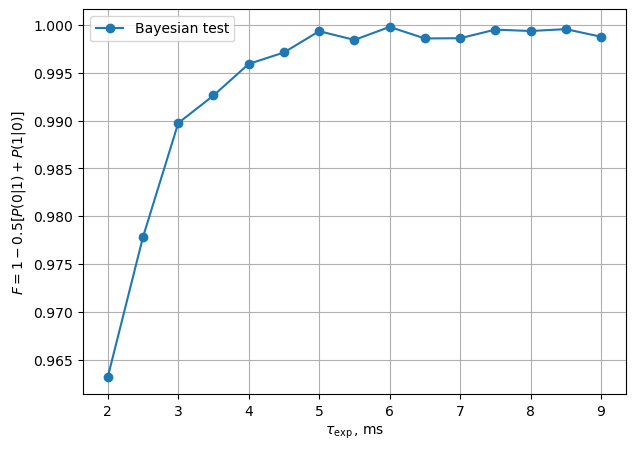

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))

data_cnt = df.groupby(by="texp").error.count()
data_mean = df.groupby(by="texp").error.mean()

ax.plot(
    data_mean.index,
    1 - data_mean.values / 2,
    "-o",
    label="Bayesian test",
    color="C0",
)
ax.set_xlabel(r"$\tau_\exp$, ms")
ax.set_ylabel(r"$F = 1 - 0.5 \left[ P(0|1) + P(1|0) \right]$")
ax.grid()
ax.legend()

plt.show()